In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action="ignore",category=FutureWarning)

在利用DPG之前，由于不太熟悉actor- critic的框架，首先尝试简单RL模型。

In [2]:
'''读取数据'''
data=pd.read_csv('STARDATA.csv').set_index('date')
data.index=pd.to_datetime(data.index.astype(str),format='%Y%m%d')

'''数据预处理，将首日的0去掉，将0替换成nan'''
data=data.replace(0,np.nan)

'''读股票信息'''
info=pd.read_csv('Stockinfo.csv')
info['code']=info['code'].astype(str)

In [3]:
train_data=data[data.index<='2021-07-31']

In [4]:
'''为获得最长的数据范围，从开板时的初始25支股票中选择标的范围'''
og_stock=train_data.iloc[0].dropna().index

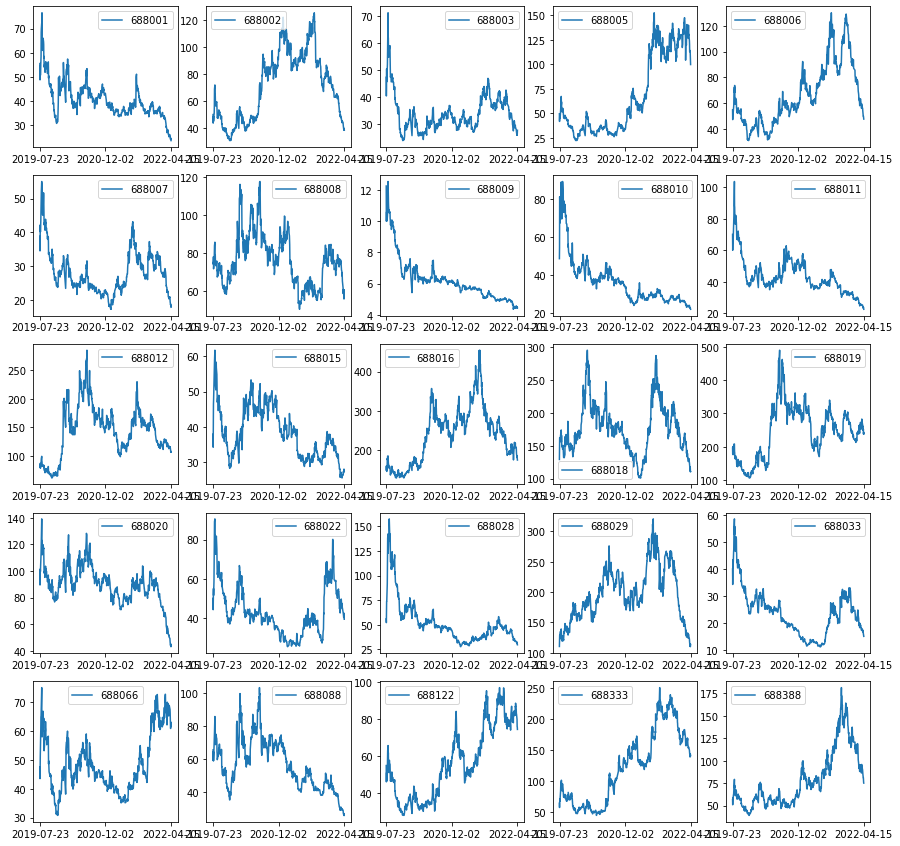

In [5]:
'''作图'''
k=1
plt.figure(1,figsize=(15,15))

for i in og_stock:
    fig=plt.subplot(5,5,k)
    k+=1
    plot1=plt.plot(data[i])
    plt.legend([i])
    plt.xticks(data[i].index[(range(1,len(data[i]),round(len(data[i])/2)-1))])
    # if k==401:
    #     break
# plt.savefig('STARprice.png') 
plt.show()

选择688001，688002，688005,688333,688029五只股票作为投资组合标的

In [6]:
stock_list=['688001','688002','688005','688333','688029','688019']
info[info['code'].isin(stock_list) ]

,code,name,industry,cmv,mv,pe,csc
62,688005,容百科技,材料,2.914487e+10,4.734414e+10,51.967,275810300
63,688019,安集科技,材料,7.603742e+09,1.319870e+10,105.519,30660252
249,688333,铂力特,工业,6.658262e+09,1.164929e+10,-218.538,46177001
260,688001,华兴源创,信息技术,1.203051e+09,1.048816e+10,33.405,50400105
351,688029,南微医学,医疗保健,5.308550e+09,1.599082e+10,61.324,44400720
387,688002,睿创微纳,信息技术,1.047639e+10,1.817101e+10,39.401,257152320


但5支标的对于我还是太难了，先考虑自己写一个强化学习的简单例子，一只股票的买卖。以688002为例

In [7]:
class rl_model():
    def __init__(self):
        self.model=tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=20,activation='relu',input_shape=(5,)),
            tf.keras.layers.Dense(units=3,activation='relu')
        ])

    def get_model(self):
        return self.model

In [8]:
'''测试神经网络输出'''
model=rl_model().get_model()
ans1=model.predict([[1,2,2,3,4]])
action=tf.random.categorical(ans1,num_samples=1)
print(action)
action=action.numpy().flatten()
print('action value',(action==0))

stock='688020'
one_stock_data=train_data[stock]
slice_data=one_stock_data['2019-07-23']
print(dict(name='lily',sex='famale'))

tf.Tensor([[1]], shape=(1, 1), dtype=int64)
action value [False]
{'name': 'lily', 'sex': 'famale'}


2022-06-06 11:17:35.390036: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# 利用policy gradient实现简单的单股票择时交易

In [802]:
class agent():
    '''
    state: dict(money,position,wealth)
    '''
    def __init__(self,initial_capital,stock_list):

        self.initial_capital=initial_capital
        self.state=dict(money=initial_capital,position=0,wealth=initial_capital)
        self.stock_list=stock_list
        self.datetag=[]
        self.action=[]
        self.memory=pd.DataFrame(columns=['datetag','money','position','wealth','action','log_return','reward'])
        self.action_sequence=[]
        self.logits=[]


    
    def init_state(self):
        self.state=dict(money=self.initial_capital,position=0,wealth=self.initial_capital)

    def take_action(self,logits):
        '''
        action [0]: sell
        action [1]: buy
        action [2]: hold
        :param observation:
        :return:
        '''

        probs= tf.nn.softmax(logits)
        # print(probs)
        
        self.action = tf.random.categorical(probs, num_samples=1)
        # self.action = tf.constant([[round(np.mean(tf.random.categorical(probs, num_samples=10)))]])
        # print('probs:',probs)
        # print('action:',self.action)
        # self.action = action.numpy().flatten()
        self.action_sequence.append(self.action)
        self.logits.append(logits)
        return self.action

    def update_state(self,d_state):
        self.state['money'] += d_state['money']
        self.state['position'] += d_state['position']
        self.state['wealth'] = d_state['wealth']
        self.state['action'] = d_state['action']

    def update_memory(self,datetag):
        self.memory=self.memory.append(dict(datetag=datetag,money=self.state['money'],position=self.state['position'],
                                wealth=self.state['wealth'],action=self.state['action'],log_return=0,reward=0),ignore_index=True)

    def clear_memory(self):
        self.memory=self.memory.drop(index=self.memory.index)
        self.action_sequence=[]
        self.logits=[]

    def calculate_reward(self,gamma=0.9):
        self.memory['log_return']=np.log(self.memory['wealth'].astype(float)) - np.log(self.memory['wealth'].astype(float)).shift(1)
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            R = R * gamma + t
            discounted_rewards[-i - 1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
        
    def calculate_second_reward(self,gamma=0.9):
        self.memory['log_return']=self.memory['wealth'].astype(float) - self.memory['wealth'].astype(float).shift(1)
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            R = R * gamma + t
            discounted_rewards[-i - 1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    
    def calculate_third_reward(self,gamma=0.9):
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['wealth'])):
            q= 100 if t>10000 else -200
            R = R * gamma + q
            discounted_rewards[-i -1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    
    def calculate_fourth_reward(self,gamma=0.9):
        self.memory['reward'] = (self.state['wealth']/self.initial_capital)-1
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    def calculate_fifth_reward(self,gamma=0.9):
        self.memory['log_return']=self.memory['wealth'].astype(float) - self.memory['wealth'].astype(float).shift(1)
        
        self.memory.loc[self.memory['action']==0,'log_return']=0
        
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            q= 1 if t>0 else -1
            if i==0:
                if self.state['wealth']>self.initial_capital:
            # discounted_rewards[-1]=discounted_rewards[-1]+(self.state['wealth']-self.initial_capital)
                    q=q+100
                elif self.state['wealth'] == self.initial_capital:
                    q=q-50
                else:
                    q=q-100
                
            R = R * gamma + q
            discounted_rewards[-i - 1] = R

        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        
    def calculate_sixth_reward(self,gamma=0.9):
        
        self.memory['log_return']=self.memory['wealth'].astype(float) - self.memory['wealth'].astype(float).shift(1)
        
        # self.memory.loc[self.memory['action']==0,'log_return']=0  
        
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            q= t
            if i==0:
                q+=self.state['wealth']-self.initial_capital
                # if self.state['wealth']>self.initial_capital:
                #     q=q+10000
                # elif self.state['wealth'] == self.initial_capital:
                #     q=q-5000
                # else:
                #     q=q-10000
                
            R = R * gamma + q
            discounted_rewards[-i - 1] = R

        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        

In [106]:
class market_env():
    def __init__(self,data,stock):
        self.data=data[stock]
    def reveive_action(self,action,state,datetag):
        price = self.data[datetag]
        # print('action:',action)
        if action==[1]:
            '''buy'''
            if state['money']>=price:
                volume = np.floor(state['money'] / price)
                d_money = -(volume * price)
                d_position = volume
            else:
                d_money = 0
                d_position = 0
        if action==[0]:
            '''sell'''
            earn=state['position']*price
            d_money=earn
            d_position=-state['position']
        if action==[2]:
            d_money=0
            d_position=0
        new_wealth=state['money']+state['position']*price
        return dict(money=d_money,position=d_position,wealth=new_wealth,action=action)

In [803]:
def trade_bot(num_units,num_actions,input_num):
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=num_units, 
                                                              activation='relu',
                                                              input_shape=(input_num,)),
                                        tf.keras.layers.Dense(units=num_actions)])
    return model

## 准备训练数据,开始训练过程  
1. 首先只将五日数据作为X输入
2. 再尝试将五日数据，和当前持仓状态作为输入

DatetimeIndex(['2019-07-22', '2019-07-23', '2019-07-24', '2019-07-25',
               '2019-07-26', '2019-07-29', '2019-07-30', '2019-07-31',
               '2019-08-01', '2019-08-02',
               ...
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-26', '2021-07-27', '2021-07-28',
               '2021-07-29', '2021-07-30'],
              dtype='datetime64[ns]', name='date', length=494, freq=None) -0.03066271018793265


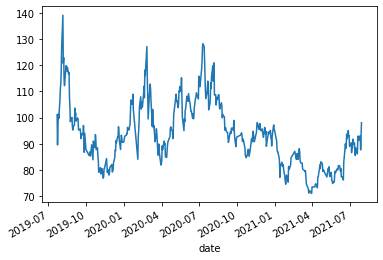

In [11]:
'''了解该股票训练期间价格走向'''
one_stock_data.plot()
print(one_stock_data.index,(one_stock_data[-1]/one_stock_data[0])-1)

In [203]:
'''compute loss'''
def compute_loss(logits, actions, rewards_aaa): 
    # neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    neg_logprob=tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
    loss = tf.reduce_mean(neg_logprob*rewards_aaa)
    # loss = neg_logprob*rewards_aaa
    
    return loss

In [ ]:
def calculate_reward():
    pass

In [849]:
'''test train code'''
T=6
stock='688008'
one_stock_data=train_data[stock]

'''尝试将x转化为log收益率，将收益率作为模型输入'''
# log_return=np.log(one_stock_data) - np.log(one_stock_data).shift(1)
# log_return=log_return.fillna(0)
# log_return=log_return*10
# x=np.array([log_return[i-T:i] for i in range(T,len(log_return))])   

'''直接利用价格作为模型输入'''
x=np.array([one_stock_data[i-T:i] for i in range(T,len(one_stock_data))])
'''尝试将x标准化'''
# x=(x-np.mean(x))/np.std(x)
trade_model=trade_bot(32,3,input_num=(T+2))
trader1=agent(initial_capital=10000,stock_list=[stock])
mrk1=market_env(train_data,stock)

遇到的问题：仅用若干天价格输入，网络学习不到任何有用的信息。训练结果不收敛。   
进一步测试的内容：   
1. 略微增加网络层数
2. 在输入中添加特征
3. 更重要的问题是，我衡量的标准是最终wealth的积累，但这个标准不是reward和loss的标准，所以导致了这些差异。   
4. 还有一个想法：是不是可以搜索出那个最优的决策模型

In [852]:
'''训练过程，并记录训练过程中出现的最佳模型'''
episode=50
learning_rate = 1e-7
optimizer = tf.keras.optimizers.Adam(learning_rate)
record=[]
milestone=0

former_layer_weight=trade_model.get_weights()

for k in range(episode):
    '''初始化模型state 和 起始资金'''
    trader1.init_state()
    trader1.clear_memory()
    obs_set=np.empty((0,T+2),float)
      
    logits = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    actions = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    
    with tf.GradientTape() as tape: 
        '''根据当前模型预测交易行为0卖，1买，2不变'''
        for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
            # observation=np.expand_dims(x[i],axis=0)
            '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
            observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
            observation=tf.expand_dims(observation,axis=0)
            obs_set=np.vstack((obs_set,observation))
        
            '''将observation输入模型'''
            logit=trade_model(observation)
           
            logits = logits.write(i, tf.squeeze(logit))
            action=trader1.take_action(logit)
            actions=actions.write(i, tf.squeeze(action))
            d_state=mrk1.reveive_action(action,trader1.state,j)
            # print(d_state)
            trader1.update_state(d_state)
            trader1.update_memory(j)
  
        record.append(trader1.state['wealth'])
    
        '''计算reward：gamma=0.9 效果不好 '''
        trader1.calculate_second_reward(gamma=0.5)
    
        '''记录最佳模型'''
        if trader1.state['wealth']>milestone:
            best_model=trade_model
            best_memory=trader1.memory
            milestone=trader1.state['wealth']
    
    
        reward_sdz=(trader1.memory['reward']-np.mean(trader1.memory['reward']))/(np.std(trader1.memory['reward'])+0.00001)
            # reward_sdz=(trader1.memory['reward'])/np.std(trader1.memory['reward'])
            # reward_sdz=(trader1.memory['reward'])
    
        reward_sdz=tf.convert_to_tensor(reward_sdz.fillna(0),dtype=tf.float32)
        vanila_reward=trader1.memory['reward']
        vanila_reward=vanila_reward.fillna(0)
            # print('reward:',reward_sdz)
            # print(np.shape(obs_set))
            # print(obs_set)
    
        '''模型参数更新'''
        # actions=tf.convert_to_tensor(np.squeeze(np.squeeze(trader1.action_sequence,axis=1),axis=1))
        # logits=tf.convert_to_tensor(np.squeeze(trader1.logits,axis=1),dtype=tf.float32)
        
        actions=actions.stack()
        logits=logits.stack()
        
        # print('logits:',tf.shape(logits))
        # print('actions:',tf.shape(actions))
        # print('rewards:',tf.shape(reward_sdz))
        loss=compute_loss(logits,actions,reward_sdz)
        # print('loss',loss)
        
    grads=tape.gradient(loss,trade_model.trainable_variables)
    # print('grads',grads)
    optimizer.apply_gradients(zip(grads, trade_model.trainable_variables))

    print('epoch#',k,'loss:',np.mean(loss),' wealth:',trader1.state['wealth'])
    # print('trainable variables:',trader1.model.trainable_variables)
    # print('grads: ',grads)
    
    '''查看权值更新情况'''
    # first_layer_weight=trader1.model.get_weights()
    # weights_diff=np.array(first_layer_weight)-np.array(former_layer_weight)
    # former_layer_weight=first_layer_weight
    # print('weights_diff: ',weights_diff)


epoch# 0 loss: 0.50471145  wealth: 12067.32
epoch# 1 loss: -0.073698126  wealth: 10594.809999999985
epoch# 2 loss: -0.4146289  wealth: 9097.880000000001
epoch# 3 loss: 2.155413  wealth: 6061.139999999994
epoch# 4 loss: -1.3901081  wealth: 9560.100000000013
epoch# 5 loss: -0.07646525  wealth: 15834.569999999989
epoch# 6 loss: -0.8189412  wealth: 9154.039999999994
epoch# 7 loss: -3.195273  wealth: 6741.800000000002
epoch# 8 loss: 0.55904454  wealth: 9121.929999999991
epoch# 9 loss: 2.786875  wealth: 7602.710000000012
epoch# 10 loss: -3.707947  wealth: 11512.740000000007
epoch# 11 loss: 0.84071296  wealth: 12488.760000000006
epoch# 12 loss: -1.4537746  wealth: 7322.669999999987
epoch# 13 loss: 1.4032333  wealth: 3955.4000000000024
epoch# 14 loss: -2.7949324  wealth: 15467.770000000006
epoch# 15 loss: -0.019343922  wealth: 12053.15999999999
epoch# 16 loss: 0.49726343  wealth: 7262.909999999999
epoch# 17 loss: 0.51651335  wealth: 7705.610000000009
epoch# 18 loss: -0.05167585  wealth: 8176.2

In [814]:
'''探索过程在tape外'''
'''训练过程，并记录训练过程中出现的最佳模型'''
episode=500
learning_rate = 1e-7
optimizer = tf.keras.optimizers.Adam(learning_rate)
record=[]
milestone=0

former_layer_weight=trade_model.get_weights()

for k in range(episode):
    '''初始化模型state 和 起始资金'''
    trader1.init_state()
    trader1.clear_memory()
    obs_set=np.empty((0,T+2),float)
    '''根据当前模型预测交易行为0卖，1买，2不变'''
    for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
        # observation=np.expand_dims(x[i],axis=0)
        '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
        observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
        observation=np.expand_dims(observation,axis=0)
        obs_set=np.vstack((obs_set,observation))
        
        '''将observation输入模型'''
        logits=trade_model(observation)
        action=trader1.take_action(logits)
        d_state=mrk1.reveive_action(trader1.action,trader1.state,j)
        # print(d_state)
        trader1.update_state(d_state)
        trader1.update_memory(j)
  
    record.append(trader1.state['wealth'])
    
    '''计算reward：gamma=0.9 效果不好 '''
    trader1.calculate_second_reward(gamma=0.5)
    
    '''记录最佳模型'''
    if trader1.state['wealth']>milestone:
        best_model=trade_model
        best_memory=trader1.memory
        milestone=trader1.state['wealth']
    
    
    reward_sdz=(trader1.memory['reward']-np.mean(trader1.memory['reward']))/(np.std(trader1.memory['reward'])+0.00001)
    # reward_sdz=(trader1.memory['reward'])/np.std(trader1.memory['reward'])
    # reward_sdz=(trader1.memory['reward'])
    
    reward_sdz=reward_sdz.fillna(0)
    vanila_reward=trader1.memory['reward']
    vanila_reward=vanila_reward.fillna(0)
    # print('reward:',reward_sdz)
    
    # print(np.shape(obs_set))
    # print(obs_set)
    
    '''模型参数更新'''
    actions=np.array(np.squeeze(np.squeeze(trader1.action_sequence,axis=1),axis=1))
    
    with tf.GradientTape() as tape:        
        logits=trade_model(obs_set)
        loss=compute_loss(logits,actions,reward_sdz)
        
    grads=tape.gradient(loss,trade_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, trade_model.trainable_variables))

    print('epoch#',k,'loss:',np.mean(loss),' wealth:',trader1.state['wealth'])
    # print('trainable variables:',trader1.model.trainable_variables)
    # print('grads: ',grads)
    
    '''查看权值更新情况'''
    # first_layer_weight=trader1.model.get_weights()
    # weights_diff=np.array(first_layer_weight)-np.array(former_layer_weight)
    # former_layer_weight=first_layer_weight
    # print('weights_diff: ',weights_diff)

epoch# 0 loss: -0.64310586  wealth: 14638.319999999987
epoch# 1 loss: -0.85731137  wealth: 9537.37999999999
epoch# 2 loss: -1.4009268  wealth: 8913.50000000001
epoch# 3 loss: 1.5552374  wealth: 6373.77
epoch# 4 loss: -1.8350936  wealth: 7624.129999999989
epoch# 5 loss: -0.6529733  wealth: 13690.589999999993
epoch# 6 loss: -0.54803467  wealth: 9356.330000000004
epoch# 7 loss: -1.2814584  wealth: 12225.760000000006
epoch# 8 loss: -1.0257756  wealth: 6098.7599999999975
epoch# 9 loss: -0.73406696  wealth: 13338.769999999995
epoch# 10 loss: -2.255018  wealth: 10497.409999999998
epoch# 11 loss: 0.8761018  wealth: 9274.740000000003
epoch# 12 loss: -1.6289907  wealth: 7855.860000000009
epoch# 13 loss: -3.340003  wealth: 8255.059999999994
epoch# 14 loss: -2.8701508  wealth: 9867.37000000001
epoch# 15 loss: -1.0351714  wealth: 5392.939999999992
epoch# 16 loss: -1.282185  wealth: 9046.820000000003
epoch# 17 loss: -0.62507063  wealth: 8736.879999999997
epoch# 18 loss: -1.436379  wealth: 11646.9500

KeyboardInterrupt: 

0.36428514, -0.08330367
3.65246117e-01, -8.39211643e-02
3.65246117e-01, -8.39211643e-02

问题是：   
1. 在采取行动时的随机采样波动性太强了，导致模型系数相同时，相同输入的结果也完全不同。
2. 神经网络模型对输入不敏感，对于不同的输入，输出总是同一种action的probs最高，差异性完全由随机采样产生。


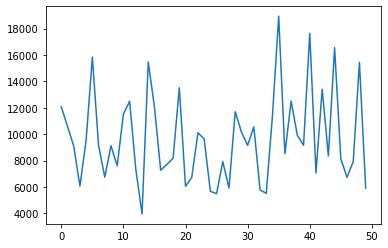

In [853]:
plt.plot(record)

0


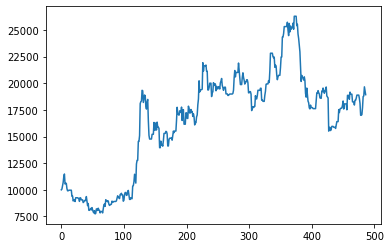

In [1032]:
'''查看一轮训练后，实现最高wealth的agent'''
best_memory['wealth'].plot()
print(milestone)

In [20]:
# best_model.save_weights(filepath='/Users/jingyugao/Desktop/学习/量化/rl')
# best_memory.to_csv('best_model_record.csv')

In [181]:
trader1.memory

,datetag,money,position,wealth,action,log_return,reward
0,2019-07-29 00:00:00,6.28,134.0,10000.0,"((tf.Tensor(1, shape=(), dtype=int64)))",NaN,96.394701
1,2019-07-30 00:00:00,6.28,134.0,10069.68,"((tf.Tensor(1, shape=(), dtype=int64)))",69.68,29.683002
2,2019-07-31 00:00:00,6.28,134.0,10360.46,"((tf.Tensor(1, shape=(), dtype=int64)))",290.78,-290.107776
3,2019-08-01 00:00:00,10699.48,0.0,10699.48,"((tf.Tensor(0, shape=(), dtype=int64)))",339.02,-699.030862
4,2019-08-02 00:00:00,47.99,127.0,10699.48,"((tf.Tensor(1, shape=(), dtype=int64)))",0.00,-776.700958
...,...,...,...,...,...,...,...
482,2021-07-22 00:00:00,8441.13,0.0,8441.13,"((tf.Tensor(2, shape=(), dtype=int64)))",0.00,206.6787
483,2021-07-23 00:00:00,36.17,131.0,8441.13,"((tf.Tensor(1, shape=(), dtype=int64)))",0.00,229.643
484,2021-07-26 00:00:00,36.17,131.0,8827.58,"((tf.Tensor(2, shape=(), dtype=int64)))",386.45,-174.23
485,2021-07-27 00:00:00,8653.35,0.0,8653.35,"((tf.Tensor(0, shape=(), dtype=int64)))",-174.23,0.0


# 简单三日五日平均的趋势跟随策略

In [221]:
class base_trader():
    '''
    state: dict(money,position,wealth)
    '''
    def __init__(self,initial_capital,stock_list):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(units=5, activation='relu',input_shape=(5,)),
            # tf.keras.layers.LSTM(units=5),
            tf.keras.layers.Dense(units=3)
        ])
        self.initial_capital=initial_capital
        self.state=dict(money=initial_capital,position=0,wealth=initial_capital)
        self.stock_list=stock_list
        self.datetag=[]
        self.action=[]
        self.memory=pd.DataFrame(columns=['datetag','money','position','wealth','action','log_return','reward'])
        self.action_sequence=[]

    def rl_model(self):
        return self.model
    
    def init_state(self):
        self.state=dict(money=self.initial_capital,position=0,wealth=self.initial_capital)

    def take_action(self,observation,t_small,t_large):
        '''
        action [0]: buy
        action [1]: hold
        action [2]: sell
        :param observation:
        :return:
        '''
        mean3=np.mean(observation[0][-t_small::])
        mean5=np.mean(observation[0][-t_large::])
        # print('ob3',observation[0][-3::],' ob5',observation[0][-7::])
        # print('mean2:',mean3,' mean5:',mean5)
        if mean3>mean5:
            self.action=[0]
        elif mean3<mean5:
            self.action=[2]
        else:
            self.action=[1]
        # self.action = action.numpy().flatten()
        self.action_sequence.append(self.action)
        return self.action

    def update_state(self,d_state):
        self.state['money'] += d_state['money']
        self.state['position'] += d_state['position']
        self.state['wealth'] = d_state['wealth']
        self.state['action'] = d_state['action']

    def update_memory(self,datetag):
        self.memory=self.memory.append(dict(datetag=datetag,money=self.state['money'],position=self.state['position'],
                                wealth=self.state['wealth'],action=self.state['action'],log_return=0,reward=0),ignore_index=True)

    def clear_memory(self):
        self.memory=self.memory.drop(index=self.memory.index)
        self.action_sequence=[]

    def calculate_reward(self,gamma=0.9):
        self.memory['log_return']=np.log(self.memory['wealth'].astype(float)) - np.log(self.memory['wealth'].astype(float)).shift(1)
        discounted_rewards = np.zeros_like(self.memory['reward'])
        R = 0
        for i, t in zip(range(len(self.memory)), reversed(self.memory['log_return'])):
            R = R * gamma + t
            discounted_rewards[-i - 1] = R
        self.memory['reward'] = discounted_rewards
        self.memory['reward']=self.memory['reward'].shift(-1)
        self.action=self.memory['action']
        

In [222]:
stock_code='688008'
# for T in range(1,11):
for T in [6]:
    # for p in range(1,T):
    for p in [3]:
        x_2=np.array([train_data[stock_code][i-T:i] for i in range(T,len(train_data[stock_code]))])
        trader_base=base_trader(initial_capital=10000,stock_list=[stock_code])
        mrk1=market_env(train_data,stock_code)
        for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
            observation=np.expand_dims(x_2[i],axis=0)
            action=trader_base.take_action(observation,p,T) 
            d_state=mrk1.reveive_action(trader_base.action,trader_base.state,j)
             # print(d_state)
            trader_base.update_state(d_state)
            trader_base.update_memory(j)
        print('large_gap:',T,'small_gap:',p,'state:',trader_base.state['wealth'],'std',np.std(trader_base.memory['wealth']))
# print(trader_base.memory)

large_gap: 6 small_gap: 3 state: 10000.0 std 0.0


best try--large_gap: 6 small_gap: 4 state: 13387.5 std 1847.778642672263

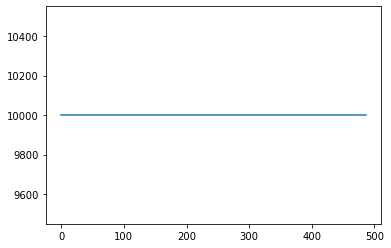

In [1031]:
plt.plot(trader_base.memory['wealth'])

# 强化学习训练中遇到的问题梳理
## 检查输入对数收益率的分布情况

(array([  2.,   0.,   3.,  18.,  92., 258., 101.,  15.,   3.,   2.]),
 array([-0.2230918 , -0.18255047, -0.14200913, -0.1014678 , -0.06092646,
        -0.02038512,  0.02015621,  0.06069755,  0.10123888,  0.14178022,
         0.18232156]),
 <BarContainer object of 10 artists>)

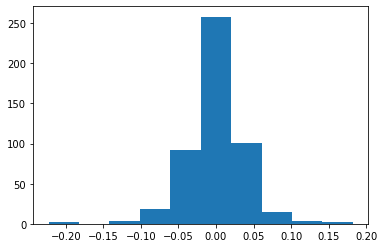

In [1416]:
plt.hist(log_return)

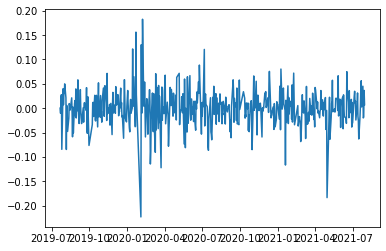

In [1418]:
plt.plot(log_return)

## 检查价格的分布情况

(array([18., 58., 88., 84., 75., 89., 38., 20., 12., 12.]),
 array([ 50.39 ,  57.107,  63.824,  70.541,  77.258,  83.975,  90.692,
         97.409, 104.126, 110.843, 117.56 ]),
 <BarContainer object of 10 artists>)

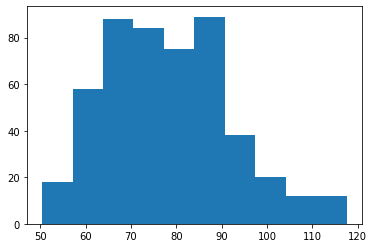

In [1419]:
plt.hist(one_stock_data)

## 强化学习训练不收敛的问题   
经过一段时间对参数、reward function、学习率等一系列模型要素的调整，发现训练结果仍然不收敛。训练结果发散是强化学习常见的问题，需要额外考虑更加系统性的解决办法。    
思考1: 只将正例纳入训练
   2:利用actor- critic来降低波动

# Actor-Critic方法和引入Critic的门特卡洛方法

## actor-critic模型

In [1094]:
'''actor-critic model'''
class ACmodel(tf.keras.Model):
    def __init__(self,units_num,action_nums,T):
        super().__init__()
        self.common_layer=tf.keras.layers.Dense(units_num,activation='leaky_relu',input_shape=(T,))
        # self.common_layer2=tf.keras.layers.Dense(18,activation='leaky_relu')
        self.action_layer=tf.keras.layers.Dense(action_nums)
        self.critic_layer=tf.keras.layers.Dense(1)
    def __call__(self,x):
        mid_x=self.common_layer(x)
        # mid_x=self.common_layer2(mid_x)
        return self.action_layer(mid_x),self.critic_layer(mid_x)

In [1095]:
class ACagent(agent):
    def __init__(self,initial_capital,stock_list):
        self.initial_capital=initial_capital
        self.state=dict(money=initial_capital,position=0,wealth=initial_capital)
        self.action=[]
        self.memory=pd.DataFrame(columns=['datetag','money','position','wealth','action','log_return','reward'])
        self.action_sequence=[]
        self.logits=[]
        self.critic_values=[]
        self.action_probs=[]
    
    def take_action(self,logits,value):
        '''
        action [0]: sell
        action [1]: buy
        action [2]: hold
        :param observation:
        :return:
        '''
        # logits,value = self.model(observation)
        probs= tf.nn.softmax(logits)
        self.action = tf.random.categorical(probs, num_samples=1)
  
        return self.action
    def clear_memory(self):
        super().clear_memory()
        self.logits=[]
        self.critic_values=[]
        self.action_probs=[]

In [1147]:
'''compute loss'''
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)
def compute_ACloss(action_probs, critic_values, returns): 
    advantage = returns- critic_values
    # print('advantage',tf.reduce_sum(advantage))

    action_log_probs = tf.math.log(action_probs)
    # print('action_log_probs',action_log_probs)
    actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)
    # print('actor_loss',actor_loss)

    critic_loss = huber_loss(critic_values, returns)
    # print('critic_loss',critic_loss)
    return  actor_loss+critic_loss           


In [1153]:
def run_episode(acmodel,trader2,mrk1,record,milestone):
    trader2.init_state()
    trader2.clear_memory()
    obs_set=np.empty((0,T+2),float)
    
    action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    critic_values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    
    '''根据当前模型预测交易行为0卖，1买，2不变'''
    for i,j in zip(range(len(mrk1.data.index[T-1:-2])),mrk1.data.index[T-1:-2]):
        '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
        observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
        observation=tf.expand_dims(observation,axis=0)
        obs_set=np.vstack((obs_set,observation))
    
        '''将observation输入模型'''
        logits,value=acmodel(observation)
        probs= tf.nn.softmax(logits)
        critic_values=critic_values.write(i,tf.squeeze(value))
        '''take action 里的步骤'''
        action=trader2.take_action(logits,value)
        try:
            act_prob=probs[0,action[0,0]]
        except:
            print('failure:',action)
        
        action_probs=action_probs.write(i,act_prob)
        
        d_state=mrk1.reveive_action(action,trader2.state,j)
        # print(d_state)
        trader2.update_state(d_state)
        
        '''update_memory'''
        trader2.update_memory(j)
        
    record.append(trader2.state['wealth'])
    
    '''计算reward：gamma=0.9 效果不好 '''
    trader2.calculate_second_reward(gamma=0.9)
    
    '''记录最佳模型'''
    if trader2.state['wealth']>milestone:
        best_model=acmodel
        best_memory=trader2.memory
        milestone=trader2.state['wealth']
    
    
    reward_sdz=(trader2.memory['reward']-np.mean(trader2.memory['reward']))/(np.std(trader2.memory['reward'])+0.00001)
    reward_sdz=tf.convert_to_tensor(reward_sdz.fillna(0).astype('float32'))
    vanila_reward=trader2.memory['reward']
    vanila_reward=vanila_reward.fillna(0)
    '''模型参数更新'''
    
    
    action_probs=action_probs.stack()
    critic_values=critic_values.stack()

    # action_probs=tf.expand_dims(action_probs,axis=1)
    # critic_values=tf.expand_dims(critic_values,axis=1)
    # reward_sdz=tf.expand_dims(rewards,axis=1)

    return action_probs,critic_values,reward_sdz


In [1154]:
'''test train code'''
T=6
stock='688008'
one_stock_data=train_data[stock]

'''尝试将x转化为log收益率，将收益率作为模型输入'''
# log_return=np.log(one_stock_data) - np.log(one_stock_data).shift(1)
# log_return=log_return.fillna(0)
# log_return=log_return*10
# x=np.array([log_return[i-T:i] for i in range(T,len(log_return))])   

'''直接利用价格作为模型输入'''
x=np.array([one_stock_data[i-T:i] for i in range(T,len(one_stock_data))])
'''尝试将x标准化'''
x=(x-np.mean(x))/np.std(x)

acmodel = ACmodel(128,3,T+2)
trader2=ACagent(initial_capital=10000,stock_list=[stock])
mrk1=market_env(train_data,stock)

In [1155]:
'''actor-critic训练过程，并记录训练过程中出现的最佳模型'''
episode=100
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
record=[]
loss_sequence=[]
milestone=0

former_layer_weight=acmodel.get_weights()

for k in range(episode):
    '''初始化模型state 和 起始资金'''

    with tf.GradientTape() as tape: 
        # tape.watch(trader2.model.trainable_variables)
        action_probs,critic_values,rewards=run_episode(acmodel,trader2,mrk1,record,milestone)
        
        action_probs=tf.expand_dims(action_probs,axis=1)
        critic_values=tf.expand_dims(critic_values,axis=1)
        rewards=tf.expand_dims(rewards,axis=1)
        
#         '''检查loss输入参数的shape'''
#         print('shape:action_probs',tf.shape(action_probs))
#         print('shape:critic_values',tf.shape(critic_values))
#         print('shape:rewards',tf.shape(rewards))
        
#         '''检查action_probs，critic_values，rewards'''
#         print('action_probs',action_probs)
#         print('critic_values',critic_values)
#         print('rewards',rewards)
        
        loss=compute_ACloss(action_probs,critic_values,rewards)

       
    loss_sequence.append(loss)

    grads=tape.gradient(loss,acmodel.trainable_variables)

    
    optimizer.apply_gradients(zip(grads, acmodel.trainable_variables))
    confidence=np.mean(action_probs)

    print('epoch----------',k,'loss:',np.mean(loss),' wealth:',trader2.state['wealth'],'confidence:',confidence)
    
    if confidence>0.52 and trader2.state['wealth']>20000 :
        break

    
    '''查看权值更新情况'''
    # first_layer_weight=trader2.model.get_weights()
    # weights_diff=np.array(first_layer_weight)-np.array(former_layer_weight)
    # former_layer_weight=first_layer_weight
    # print('weights_diff: ',weights_diff)


epoch---------- 0 loss: 242.90248  wealth: 9183.639999999992 confidence: 0.34564883
epoch---------- 1 loss: 133.61577  wealth: 5812.799999999991 confidence: 0.3422481
epoch---------- 2 loss: 140.53572  wealth: 7516.839999999993 confidence: 0.33842573
epoch---------- 3 loss: 140.11526  wealth: 10040.029999999993 confidence: 0.3494124
epoch---------- 4 loss: 132.8206  wealth: 8538.01999999999 confidence: 0.3417328
epoch---------- 5 loss: 52.912582  wealth: 7424.850000000013 confidence: 0.34798393
epoch---------- 6 loss: 85.91275  wealth: 9068.07 confidence: 0.34123126
epoch---------- 7 loss: 109.668594  wealth: 22079.23 confidence: 0.3519149
epoch---------- 8 loss: -9.055649  wealth: 7573.070000000008 confidence: 0.35539198
epoch---------- 9 loss: -60.864822  wealth: 5142.619999999995 confidence: 0.34004918
epoch---------- 10 loss: 16.173553  wealth: 10708.039999999999 confidence: 0.3545081
epoch---------- 11 loss: -17.75232  wealth: 16023.870000000008 confidence: 0.3642283
epoch--------

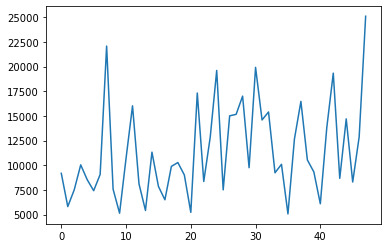

In [1156]:
plt.plot(record)


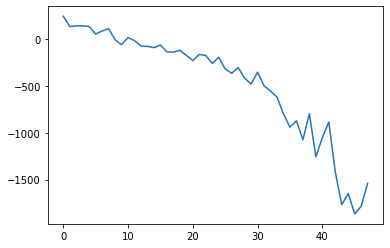

In [1157]:
plt.plot(loss_sequence)

<AxesSubplot:>

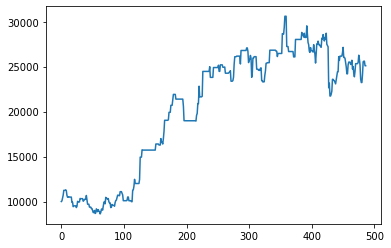

In [1158]:
trader2.memory['wealth'].plot()

0


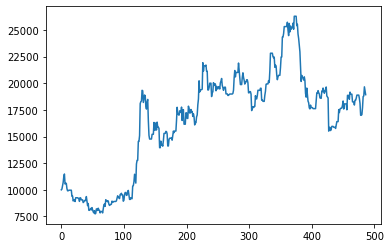

In [1159]:
'''查看一轮训练后，实现最高wealth的agent'''
best_memory['wealth'].plot()
print(milestone)

## 训练过程中出现的问题  
1. the trade-off between actor-loss and critic-loss

## 测试模型的性能   
利用

In [1164]:
'''准备数据'''
test_data=data[data.index>'2021-07-31']

T=6
stock='688008'
one_stock_test=test_data[stock]

'''尝试将x转化为log收益率，将收益率作为模型输入'''
# log_return=np.log(one_stock_data) - np.log(one_stock_data).shift(1)
# log_return=log_return.fillna(0)
# log_return=log_return*10
# x=np.array([log_return[i-T:i] for i in range(T,len(log_return))])   

'''直接利用价格作为模型输入'''
x=np.array([one_stock_test[i-T:i] for i in range(T,len(one_stock_test))])
'''尝试将x标准化'''
x=(x-np.mean(x))/np.std(x)
trader_test_performance=ACagent(initial_capital=10000,stock_list=[stock])
test_mrk=market_env(test_data,stock)

In [1163]:
def test_model_performance(x,test_mrk,trader2,acmodel):
    obs_set=np.empty((0,T+2),float)
    
    '''根据当前模型预测交易行为0卖，1买，2不变'''
    for i,j in zip(range(len(test_mrk.data.index[T-1:-2])),test_mrk.data.index[T-1:-2]):
        '''这里的observation只有前T日的价格，但模型不收敛，考虑加特征维度:将T日平均，和T/2日平均加入输入'''
        observation=np.append(x[i],[np.mean(x[i]),np.mean(x[i][-round(T/2)::])])
        observation=tf.expand_dims(observation,axis=0)
        obs_set=np.vstack((obs_set,observation))
    
        '''将observation输入模型'''
        logits,value=acmodel(observation)
        
        '''take action 里的步骤'''
        action=trader2.take_action(logits,value)
        d_state=test_mrk.reveive_action(action,trader2.state,j)
        # print(d_state)
        trader2.update_state(d_state)
        
        '''update_memory'''
        trader2.update_memory(j)
    

In [1165]:
test_model_performance(x,test_mrk,trader_test_performance,acmodel)


In [1166]:
trader_test_performance.memory

,datetag,money,position,wealth,action,log_return,reward
0,2021-08-09 00:00:00,58.63,163.0,10000.0,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
1,2021-08-10 00:00:00,10717.2,0.0,10717.2,"((tf.Tensor(0, shape=(), dtype=int64)))",0,0
2,2021-08-11 00:00:00,40.08,166.0,10717.2,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
3,2021-08-12 00:00:00,40.08,166.0,10730.48,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
4,2021-08-13 00:00:00,40.08,166.0,9998.42,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
...,...,...,...,...,...,...,...
158,2022-04-07 00:00:00,11603.36,0.0,11603.36,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
159,2022-04-08 00:00:00,58.96,190.0,11603.36,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0
160,2022-04-11 00:00:00,58.96,190.0,11306.96,"((tf.Tensor(2, shape=(), dtype=int64)))",0,0
161,2022-04-12 00:00:00,0.75,191.0,11118.86,"((tf.Tensor(1, shape=(), dtype=int64)))",0,0


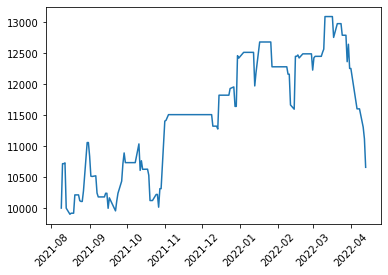

In [1179]:
plt.plot(trader_test_performance.memory['datetag'],trader_test_performance.memory['wealth'])
plt.xticks(rotation=45)
plt.show()


## 代码测试

In [995]:
class linear_model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer=tf.keras.layers.Dense(units=1,activation='leaky_relu',
                                         kernel_initializer= tf.keras.initializers.RandomNormal(mean=1, stddev=1.))
    def __call__(self,x):
        return self.layer(x)

class student():
    def __init__(self):
        self.model=linear_model()
    def run(self,x):
        return self.model(x)

# linear_m=linear_model()
mike=student()
optimizer = tf.keras.optimizers.Adam(0.1)
    
x=tf.constant([[1.],[2.],[3.],[4.],[5.]])
y=tf.constant([[2.],[4.],[6.],[8.],[10.]])

# print(linear_m(x))


iter_fit=True

for k in range(200):
    y_hat=[]
    with tf.GradientTape() as tape: 
        # tape.watch(linear_m.trainable_variables)
        if iter_fit==True:
            for i in x :
                obs=tf.expand_dims(i, 0)
                y_obs=mike.run(obs)
                y_hat.append(y_obs)
            print(tf.shape(y_hat))
            y_hat=tf.convert_to_tensor(y_hat)[:,0]
            print(tf.shape(y_hat))
            print(y_hat)
            # print('iter:',y_hat)
            # y_hat2=linear_m(x)
            # print('whole:',y_hat2)
        
        else:
            y_hat=mike.run(x)
            # print(y_hat)
            


        loss=tf.math.reduce_mean(tf.math.square(y-y_hat))
        # print('iter loss',loss)
        # print('whole loss',tf.math.reduce_mean(tf.math.square(y-y_hat2)))
        print('epoch:',k+1,'loss:',loss)
    
    grads=tape.gradient(loss,mike.model.trainable_variables)
    # print('grads',grads)
    optimizer.apply_gradients(zip(grads, mike.model.trainable_variables))
    if loss<0.07:
        break



tf.Tensor([5 1 1], shape=(3,), dtype=int32)
tf.Tensor([5 1], shape=(2,), dtype=int32)
tf.Tensor(
[[ 2.2779336]
 [ 4.555867 ]
 [ 6.833801 ]
 [ 9.111734 ]
 [11.3896675]], shape=(5, 1), dtype=float32)
epoch: 1 loss: tf.Tensor(0.84971774, shape=(), dtype=float32)
tf.Tensor([5 1 1], shape=(3,), dtype=int32)
tf.Tensor([5 1], shape=(2,), dtype=int32)
tf.Tensor(
[[ 2.0779338]
 [ 4.2558675]
 [ 6.433801 ]
 [ 8.611735 ]
 [10.789669 ]], shape=(5, 1), dtype=float32)
epoch: 2 loss: tf.Tensor(0.2515045, shape=(), dtype=float32)
tf.Tensor([5 1 1], shape=(3,), dtype=int32)
tf.Tensor([5 1], shape=(2,), dtype=int32)
tf.Tensor(
[[ 1.889763 ]
 [ 3.9733198]
 [ 6.056876 ]
 [ 8.140433 ]
 [10.22399  ]], shape=(5, 1), dtype=float32)
epoch: 3 loss: tf.Tensor(0.017198432, shape=(), dtype=float32)


In [984]:
x_test=tf.constant([[6.],[7.],[8.],[9.],[10.]])
# linear_m(x_test)
mike.run(x_test)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[11.630499],
       [13.641572],
       [15.652645],
       [17.663717],
       [19.674791]], dtype=float32)>